In [1]:
# required stuff
import sys
sys.path.insert(1, '/Users/samuelcourville/Documents/JPL/combinedModel/thermal')
sys.path.insert(1, '/Users/samuelcourville/Documents/JPL/combinedModel/aqueous')
sys.path.insert(1, '/Users/samuelcourville/Documents/JPL/combinedModel/transport')
sys.path.insert(1, '/Users/samuelcourville/Documents/JPL/combinedModel/rock')
sys.path.insert(1, '/Users/samuelcourville/Documents/JPL/combinedModel/tables')
import matplotlib.pyplot as plt
import numpy as np

# 1). Import WOW!

In [2]:
# import WOW (WOW! Ocean Worlds)
import WOW

# 2). Create model grid

In [3]:
######### define grid ##############

nr = 51       # Number of radii
maxnt = 500  # Maximum number of time steps

YR = 3.1536E7            #(Year to seconds conversion)
StartTime=3.0*10**6*YR   # Myrs
EndTime = 4567*10**6*YR  # Myrs. Stop time if maxnt is not reached Myr
Radius = 580000          # meters

# parameters for perplex grid
temp_step = 25 # how many degrees temperature difference before recalculating thermal properties? 
press_step= 10 # how many radius points between each perplex equilibration calculation

Ceres = WOW.Planet(nr,StartTime,EndTime,Radius,maxnt,temp_step,press_step)

# 3). Initialize model composition

### 3a starting temperature

In [4]:
# Starting temperature
init_Temp = 100

### 3b starting bulk composition

In [5]:
########### initialize comp ############

# Starting composition (Mass fraction of ice and rock must sum to 1)

ICE_frac=0.3

# Ice composition
init_IceComp={'H2O':100.0}#,'CO2':0,'CO':0,'NH3':2.0,'CH4':0} #,'NH3':0.1, 'CO2'}

# Rock composition
init_RockComp={"H":3.333,"C":0.00,"Mg":32.6277,"Al":0.00,"Si":15.5176,"S":0.00,"Ca":0.00,"Fe":5.0295,"O":43.4922,"Na":0.00,"N":0.00}


# Reweight rock and ice compositions so they sum to 1
sumR=0
for key in init_RockComp:    
    sumR = sumR+init_RockComp[key]
    init_RockComp[key] *= ((1.0-ICE_frac)/100)
    
sumI=0
for key in init_IceComp:    
    sumI = sumI+init_IceComp[key]
    init_IceComp[key] *= (ICE_frac/100)

    
# Old comps for testing
#init_RockComp={'F':0.15,'Q':0.15,'P':0.1,'N':0.005,'K':0.005,'L':0.01,'C':0.03,'S':0.05}
#init_RockComp={'F':0.04,'Q':0.046,'P':0.048,'N':0.0005,'K':0.0001,'L':0.001,'C':0.003,'S':0.02}
#init_RockComp={"H":11.283,"C":26.814,"Mg":0.985,"Al":0.178,"Si":10.434,"S":1.789,"Ca":0.082,"Fe":6.035,"O":40.652,"Na":0.696,"N":1.052}


### 3c starting radioisotope abundances

In [6]:
# Element starting wt%
Al_tot_abund=(1-ICE_frac) * 8370*10**-6 
K_tot_abund= (1-ICE_frac) * 559*10**-6
U_tot_abund= (1-ICE_frac) * 0.00816*10**-6
Th_tot_abund=(1-ICE_frac) * 0.0298*10**-6

# Radioisotope fractions
Al_26_27_start=5*10**-5
K_40_39_today=0.0119/100
U_235_238_today=0.71/100

# Calc initial radioisotope wt%
Al26start=Al_tot_abund*Al_26_27_start
K40start = WOW.calcOriginAbundance(K_tot_abund*K_40_39_today,"K40")
U235start= WOW.calcOriginAbundance(U_tot_abund*U_235_238_today,"U235")
U238start= WOW.calcOriginAbundance(U_tot_abund*(1-U_235_238_today),"U238")
Th232start=WOW.calcOriginAbundance(Th_tot_abund,"Th232")

# Initial radioisotope abundance
init_Radio={'Al26':Al26start,'K40':K40start,'U235':U235start,'U238':U238start,'Th232':Th232start}

### 3d intial bulk properties

In [7]:
# Starting properties
init_rho=1700 #2000.0
init_K=3.6 #2.0
init_Cp= 1444#2090.0

# initialize!
Ceres.initialize_comp(init_IceComp,init_RockComp, init_Radio, init_Temp,init_rho,init_K,init_Cp)

# 4). Run Model

In [8]:
Ceres.runModel()

Step 0 out of 500


mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.3p: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.6o: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.3p: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.6o: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.3p: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.6o: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.3p: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
mv: /Users/samuelcourville/Document

Step 100 out of 500


mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.3p: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.6o: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.3p: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.6o: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.3p: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.6o: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.3p: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
mv: /Users/samuelcourville/Document

Step 200 out of 500


mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.3p: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.6o: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.3p: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.6o: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.3p: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.6o: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.3p: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
mv: /Users/samuelcourville/Document

Step 300 out of 500


mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.3p: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.6o: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.3p: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.6o: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.3p: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.6o: No such file or directory
mv: /Users/samuelcourville/Documents/JPL/combinedModel/ariel.3p: No such file or directory
Note: The following floating-point exceptions are signalling: IEEE_UNDERFLOW_FLAG
mv: /Users/samuelcourville/Document

Step 400 out of 500


# 5). Plot results!

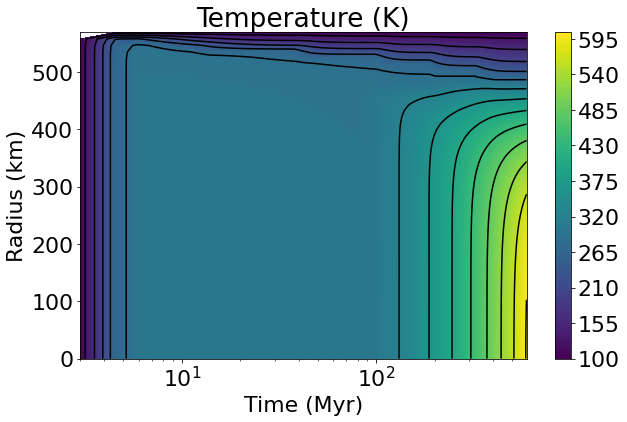

In [9]:
Ceres.plotAttribute("Temp","Temperature (K)")
plt.xscale("log")

In [10]:
print(Ceres.grid[99,45].AqSpec)

{'H+': 2.8626e-09, 'Cl-': 0.019065, 'H2(aq)': 0.0099993, 'OH-': 1.006e-06, 'Methane(aq)': 9.9993e-20, 'NH4+': 9.7623e-20, 'SiO2(aq)': 5.9197e-06, 'H2S(aq)': 2.1235e-10, 'Al+++': 7.2835e-17, 'K+': 4.6237e-09, 'Ni++': 9.9904e-20, 'Na+': 0.00099823, 'Ca++': 0.00099794, 'Fe++': 0.00036789, 'Mg++': 0.007632, 'Mn++': 9.8885e-20, 'MgCl+': 6.7693e-05, 'FeCl+': 2.5003e-06, 'CaCl+': 1.9463e-06, 'NaCl(aq)': 1.6877e-06, 'AlOH++': 2.8525e-14, 'HS-': 5.5539e-09, 'KCl(aq)': 9.8997e-13, 'CaCl2(aq)': 3.6674e-08, 'FeCl2(aq)': 1.411e-10, 'HSiO3-': 2.777e-07, 'Al(OH)2+': 2.4441e-12, 'NaHSiO3(aq)': 1.2863e-08, 'HAlO2(aq)': 1.8574e-10, 'NaOH(aq)': 1.1593e-10, 'Fe+++': nan, 'AlO2-': 8.2927e-09, 'NaAlO2(aq)': 6.1458e-13}


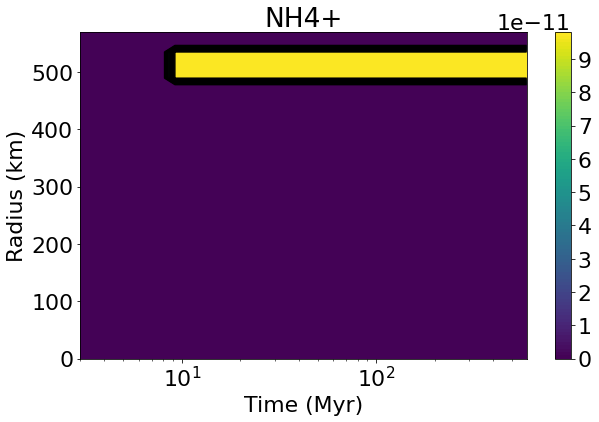

In [11]:
Ceres.plotDictAttribute("AqSpec","NH4+","NH4+",10**9)
plt.xscale("log")

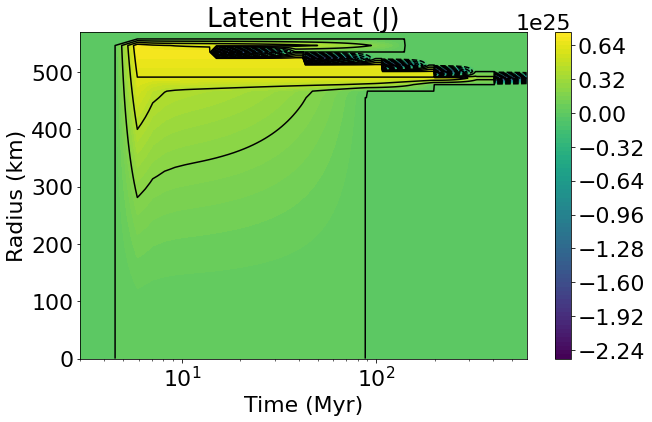

In [12]:
Ceres.plotAttribute("latentHeat","Latent Heat (J)")
plt.xscale("log")

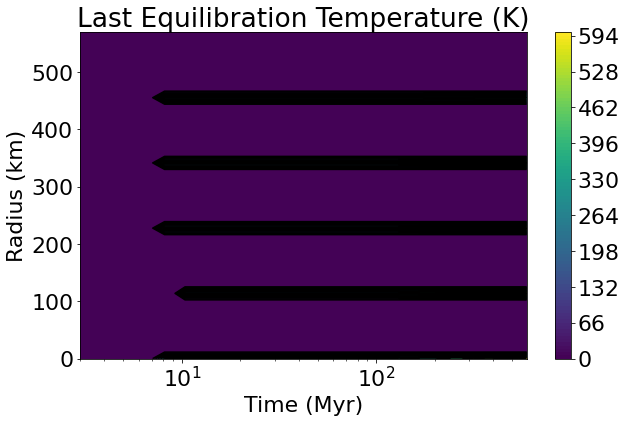

In [13]:
Ceres.plotAttribute("lastEquil","Last Equilibration Temperature (K)")
plt.xscale("log")

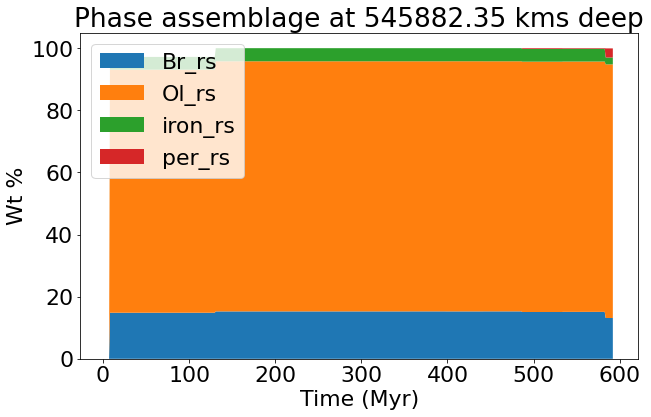

In [14]:
Ceres.plotPhaseAssemblage(3)

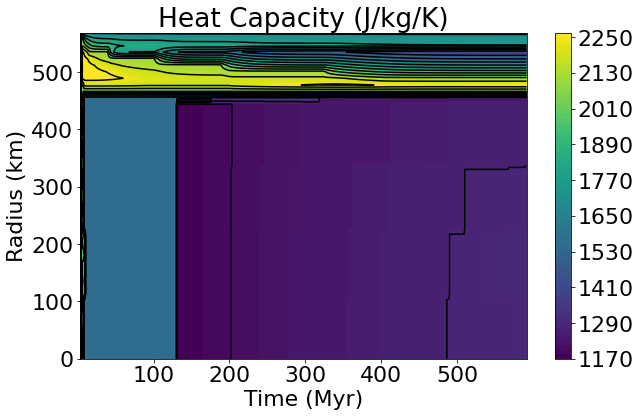

In [15]:
Ceres.plotAttribute("Cp","Heat Capacity (J/kg/K)")

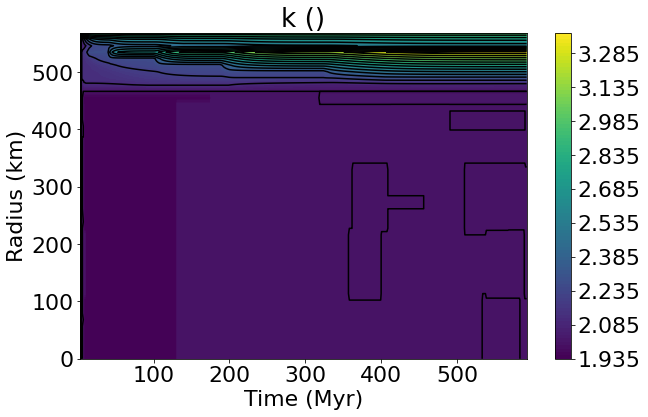

In [16]:
Ceres.plotAttribute("TCond","k ()")

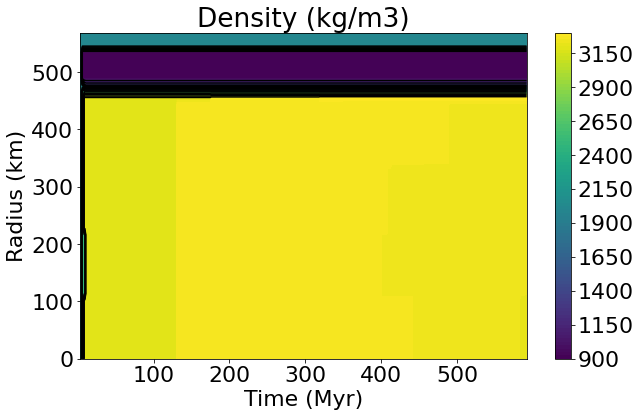

In [17]:
Ceres.plotAttribute("Dens","Density (kg/m3)")

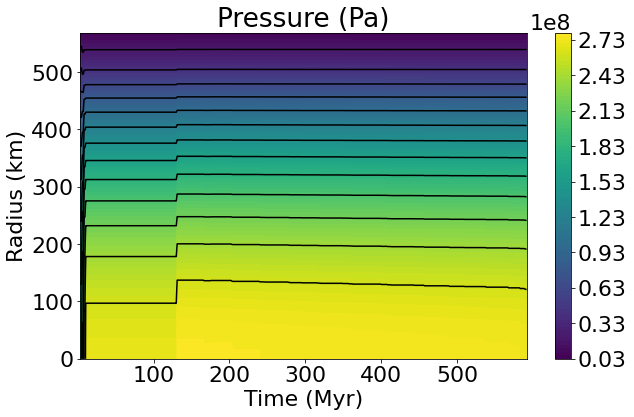

In [18]:
Ceres.plotAttribute("Press","Pressure (Pa)")

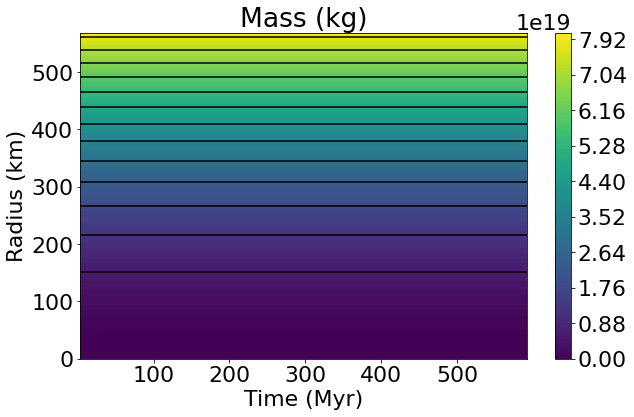

In [19]:
Ceres.plotAttribute("Mass","Mass (kg)")

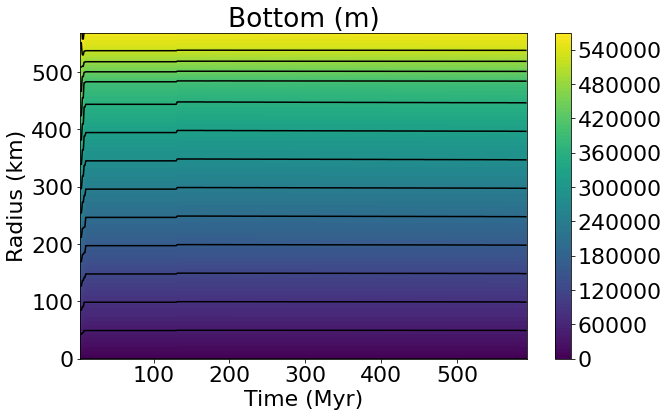

In [20]:
Ceres.plotAttribute("Bot","Bottom (m)")

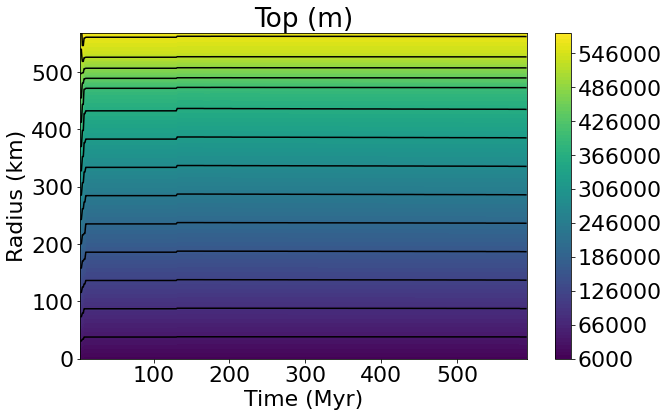

In [21]:
Ceres.plotAttribute("Top","Top (m)")

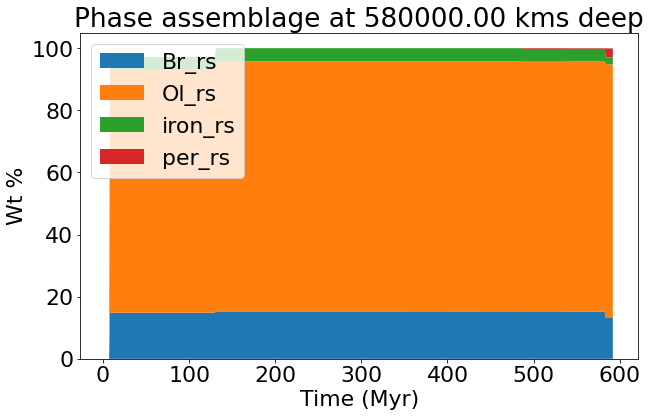

In [22]:
Ceres.plotPhaseAssemblage(0)

In [23]:
print(Ceres.grid[199,0].RockPhaseDat[1])

{'mass': 80.52, 'wt%': 80.52, 'vol%': 77.88, 'mol%': 62.76, 'mol': 0.569, 'H': 0.0, 'C': 0.0, 'Mg': 33.815, 'Al': 0.0, 'Si': 19.831, 'S': 0.0, 'Ca': 0.0, 'Fe': 1.166, 'O': 45.189, 'Na': 0.0, 'N': 0.0, 'N(g)': 141.62, 'G(J)': -2146693.0, 'S(J/K)': 205.42, 'V(J/bar)': 4.411, 'Cp(J/K)': 159.27, 'Alpha(1/K)': 3.6091e-05, 'Beta(1/bar)': 8.0718e-07, 'Cp/Cv': 1.0297, 'Density(kg/m3)': 3210.7, 'Gruneisen_T': 1.275, 'Ks(bar)': 1275600.0, 'Mu(bar)': 425210.0, 'V0(km/s)': 6.3032, 'Vp(km/s)': 7.5755, 'Vs(km/s)': 3.6392, 'Poisson_ratio': 0.35, 'Enthalpy (J/kg)': 0.0, 'Specific Enthalpy (J/m3)': 0.0, 'Entropy (J/K/kg)': 0.0, 'Specific Entropy (J/K/m3)': 0.0, 'Heat Capacity (J/K/kg)': 0.0, 'Specific Heat Capacity (J/K/m3)': 0.0}


In [24]:
#for i in range(0,1500):
#    if not Ceres.grid[i,1].RockPhaseDat:
#        print(Ceres.grid[i,0].RockPhaseDat)
#        print(i)
        
print(Ceres.grid[170,0].RockPhases)
print(Ceres.grid[170,0].RockPhaseDat[1])

['Br_rs' 'Ol_rs' 'iron_rs' 'Bulk_rs']
{'mass': 80.52, 'wt%': 80.52, 'vol%': 77.88, 'mol%': 62.76, 'mol': 0.569, 'H': 0.0, 'C': 0.0, 'Mg': 33.815, 'Al': 0.0, 'Si': 19.831, 'S': 0.0, 'Ca': 0.0, 'Fe': 1.166, 'O': 45.189, 'Na': 0.0, 'N': 0.0, 'N(g)': 141.62, 'G(J)': -2146693.0, 'S(J/K)': 205.42, 'V(J/bar)': 4.411, 'Cp(J/K)': 159.27, 'Alpha(1/K)': 3.6091e-05, 'Beta(1/bar)': 8.0718e-07, 'Cp/Cv': 1.0297, 'Density(kg/m3)': 3210.7, 'Gruneisen_T': 1.275, 'Ks(bar)': 1275600.0, 'Mu(bar)': 425210.0, 'V0(km/s)': 6.3032, 'Vp(km/s)': 7.5755, 'Vs(km/s)': 3.6392, 'Poisson_ratio': 0.35, 'Enthalpy (J/kg)': 0.0, 'Specific Enthalpy (J/m3)': 0.0, 'Entropy (J/K/kg)': 0.0, 'Specific Entropy (J/K/m3)': 0.0, 'Heat Capacity (J/K/kg)': 0.0, 'Specific Heat Capacity (J/K/m3)': 0.0}


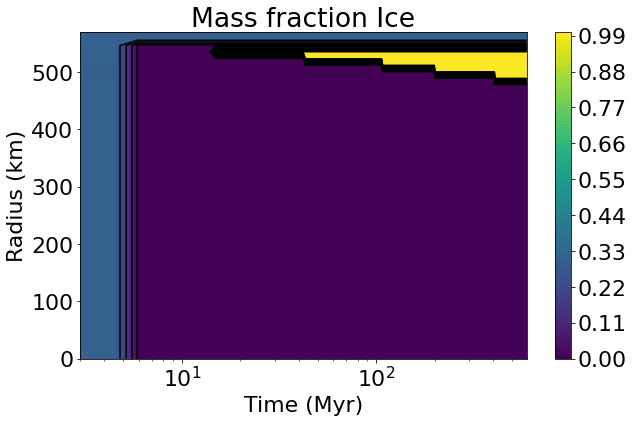

In [25]:
Ceres.plotDictAttributeMassScaled("IceComp","H2O","Mass fraction Ice",0,1)
plt.xscale("log")

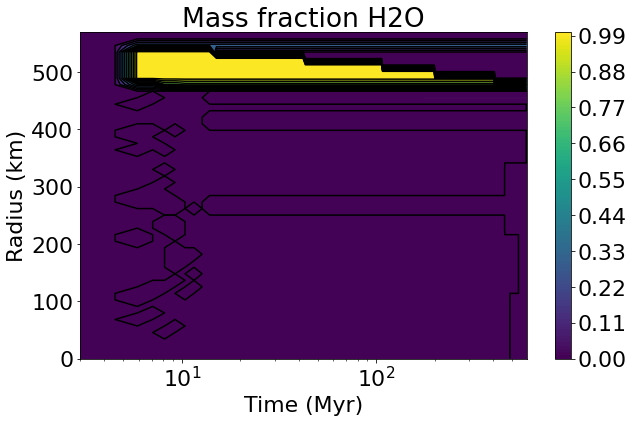

In [26]:
Ceres.plotDictAttributeMassScaled("AqComp","H2O","Mass fraction H2O",0,1)
plt.xscale("log")

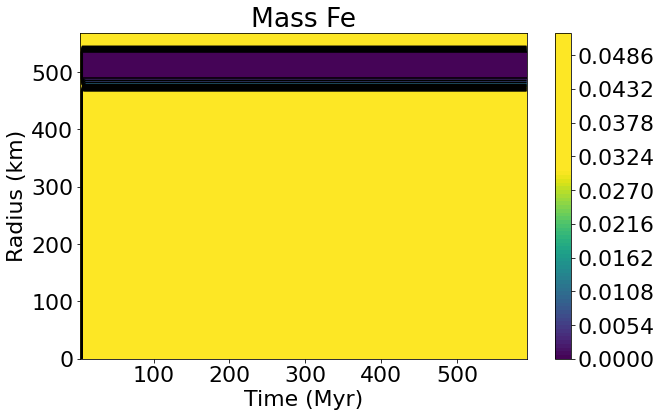

In [27]:
Ceres.plotDictAttributeMassScaled("RockComp","Fe","Mass Fe",0,0.03)

In [28]:
Ceres.grid[199,24].RockMass

1.8863605090602967e+19

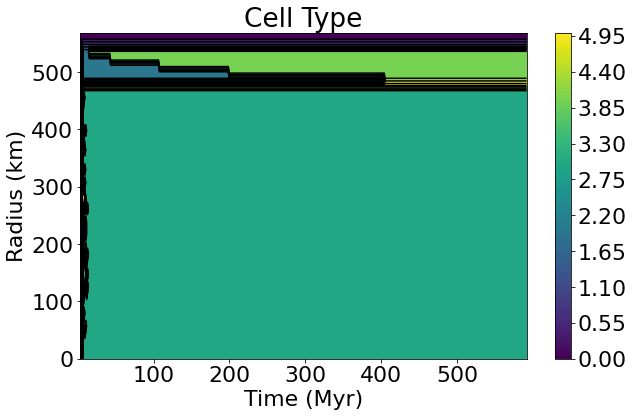

In [29]:
Ceres.plotAttribute("Celltype","Cell Type")

In [30]:
Ceres.grid[200,0].RockPhases

array(['Br_rs', 'Ol_rs', 'iron_rs', 'Bulk_rs'], dtype='<U7')

In [31]:
Ceres.grid[200,0].RockPhaseDat

[{'mass': 15.259999999999998,
  'wt%': 15.26,
  'vol%': 20.4,
  'mol%': 28.86,
  'mol': 0.261,
  'H': 3.453,
  'C': 0.0,
  'Mg': 41.58,
  'Al': 0.0,
  'Si': 0.0,
  'S': 0.0,
  'Ca': 0.0,
  'Fe': 0.143,
  'O': 54.825,
  'Na': 0.0,
  'N': 0.0,
  'N(g)': 58.37,
  'G(J)': -912697.0,
  'S(J/K)': 135.41,
  'V(J/bar)': 2.5119,
  'Cp(J/K)': 106.77,
  'Alpha(1/K)': 8.786e-05,
  'Beta(1/bar)': 2.7369e-06,
  'Cp/Cv': 1.0447,
  'Density(kg/m3)': 2323.6,
  'Gruneisen_T': 0.78902,
  'Ks(bar)': 381700.0,
  'Mu(bar)': 127230.0,
  'V0(km/s)': 4.0531,
  'Vp(km/s)': 4.8712,
  'Vs(km/s)': 2.3401,
  'Poisson_ratio': 0.35,
  'Enthalpy (J/kg)': 0.0,
  'Specific Enthalpy (J/m3)': 0.0,
  'Entropy (J/K/kg)': 0.0,
  'Specific Entropy (J/K/m3)': 0.0,
  'Heat Capacity (J/K/kg)': 0.0,
  'Specific Heat Capacity (J/K/m3)': 0.0},
 {'mass': 80.52,
  'wt%': 80.52,
  'vol%': 77.88,
  'mol%': 62.76,
  'mol': 0.569,
  'H': 0.0,
  'C': 0.0,
  'Mg': 33.815,
  'Al': 0.0,
  'Si': 19.831,
  'S': 0.0,
  'Ca': 0.0,
  'Fe': 1.166,

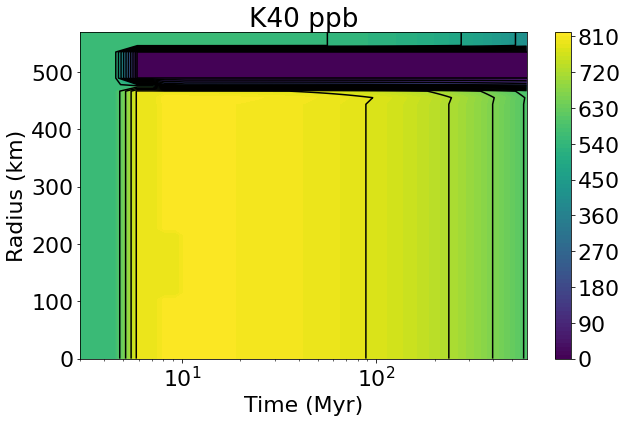

In [32]:
Ceres.plotDictAttribute("RIComp","K40","K40 ppb",10**9)
plt.xscale("log")

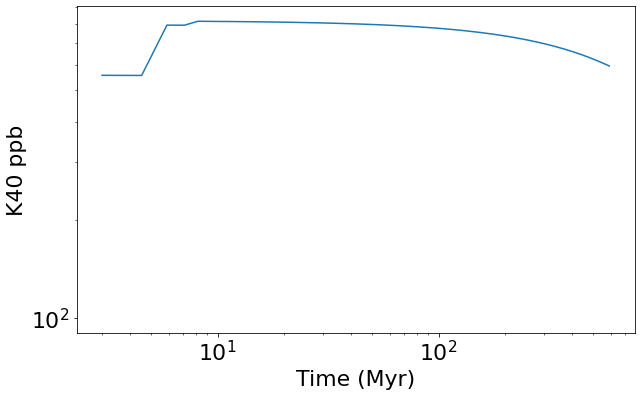

In [33]:
testPlot = Ceres.plotDictAttributeLine("RIComp","K40","K40 ppb",0,10**9)
#plt.xlim([2,12])
plt.yscale('log')
plt.xscale('log')

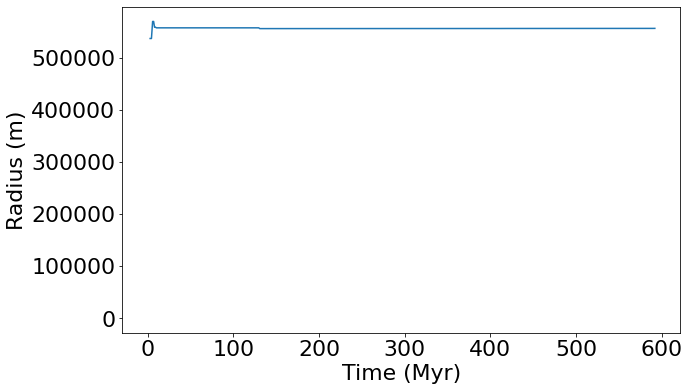

In [34]:
Ceres.plotAttributeLine("Top","Radius (m)",49)
#plt.xlim([2,12])

In [35]:
H=1.0
C=12.01
N=14.01
O=16
Na=22.99
Mg=24.31
Al=26.98
Si=28.09
S=32.07
Cl=35.45
K=39.10
Ca=40.08
Mn=54.94
Fe=55.85
Ni=58.69